Scoring the models and visualising the scores

In [1]:
from pathlib import Path
from matplotlib.patches import Patch
import os
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..') # .\SAE\
os.getcwd()
fig_path = Path("./figures/")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

import numpy as np
import torch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

%matplotlib inline

# ------- internal imports
from models import GenerativeAE
import models, metrics, experiments, datasets
from metrics import score_disentanglement 
from experiments import EvaluationManager
from experiments.EvaluationManager import ModelHandler, VisualModelHandler, VectorModelHandler
from datasets import synth_dataset 
import visualisations
from visualisations import ModelVisualiser, SynthVecDataVisualiser
from visualisations import visualise_data, visualise_model

## All scores

In [233]:
full_df = pd.read_csv("./logs/all_scores.csv", index_col=0)

In [234]:
full_df

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,INV,EQV,SCN,FID_trv,inference,INV_w,EQV_w,inferenceX,sparsity,SCN_w
0,XSAE,multidim_MNIST,MNIST,11.0,0.002063,0.012068,-80.234985,0.155638,NaN,0.703150,...,107.860870,103.264496,9.833796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XCAE,reluS_MNIST,MNIST,11.0,0.002890,0.015218,-3.865384,0.015189,NaN,0.710384,...,NaN,-18.192629,5.974104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,XCSAE,reluS_MNIST,MNIST,11.0,0.001968,0.011838,-3.686626,0.006547,NaN,0.738496,...,NaN,-2.864688,5.890009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,XCAE,multidim_MNIST,MNIST,11.0,0.002136,0.012457,-43.463146,0.073024,NaN,0.506414,...,81.656143,138.298935,11.340592,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WAE,standardSG_MNIST,MNIST,11.0,0.027534,0.200832,-100.212677,0.519379,NaN,0.919366,...,11.141309,NaN,-0.878759,90.429015,0.9500,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,BaseSAE,standardSrandom_seed37_MNIST,MNIST,37.0,0.002563,0.048183,-33.781319,0.224824,NaN,0.679664,...,0.588130,NaN,0.811556,NaN,1.0000,0.596710,NaN,NaN,NaN,0.811556
181,BaseSAE,standardrandom_seed17_MNIST,MNIST,17.0,0.003473,0.028816,-45.789330,0.100486,NaN,0.557560,...,0.626978,NaN,0.905152,NaN,0.9921,0.653072,NaN,NaN,NaN,0.905152
182,BaseSAE,standardrandom_seed37_MNIST,MNIST,37.0,0.003401,0.026861,-45.085281,0.096517,NaN,0.553555,...,0.622971,NaN,0.909370,NaN,0.9844,0.648814,NaN,NaN,NaN,0.909370
183,BaseSAE,standardrandom_seed13_MNIST,MNIST,13.0,0.003388,0.027208,-45.298416,0.098005,NaN,0.553779,...,0.630811,NaN,0.910127,NaN,0.9922,0.657029,NaN,NaN,NaN,0.910127


In [235]:
import copy
full_df2 = copy.deepcopy(full_df)

In [292]:
full_df2 = full_df2.drop(full_df2.loc[full_df2['model_version'].isna()].index)
full_df2 = full_df2.drop(full_df2.loc[full_df2['EQV']<0].index)
full_df2 = full_df2.drop(full_df2.loc[full_df2['INV']<0].index)
full_df2 = full_df2.drop(full_df2.loc[full_df2['IMQ']<=0.].index)
full_df2 = full_df2.drop(full_df2.loc[full_df2['RBF']<=0.].index)
full_df2 = full_df2.drop(full_df2.loc[full_df2['SCN']<=0.].index)
full_df2 = full_df2.drop(full_df2.loc[full_df2['SCN']>1.].index)

In [251]:
import re

def extract_version_name(full_name):
    new_name = full_name.replace("_MNIST","")
    new_name = new_name.replace("_CelebA","")
    new_name = re.sub("random_seed\d+","", new_name)
    return new_name

def extract_model_family(full_name):
    new_name = full_name.replace("X","")
    new_name = new_name.replace("C","")
    return new_name

def change_name(full_name):
    new_name = full_name.replace("BaseSAE","SAE")
    new_name = new_name.replace("BetaVAE","VAE")
    return new_name

def extract_type(full_name):
    model_type = "N"
    if 'X' in full_name: model_type = "X"
    if 'XC' in full_name: model_type = "XC"
    return model_type

In [252]:
full_df2["model_version"] = full_df2["model_version"].apply(extract_version_name)
full_df2["model_name"] = full_df2["model_name"].apply(change_name)
full_df2["model_family"] = full_df2["model_name"].apply(extract_model_family)
full_df2["model_type"] = full_df2["model_name"].apply(extract_type)

In [253]:
full_df2 = full_df2.drop(full_df2.loc[full_df2['model_family']=='WAE'].index)

In [254]:
full_df2.head()

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,SCN,FID_trv,inference,INV_w,EQV_w,inferenceX,sparsity,SCN_w,model_family,model_type
13,XCAE,xunit_dim3,MNIST,11.0,0.002065,0.030709,-50.097313,0.253537,NaN,0.636858,...,0.901519,78.119601,0.9844,0.890631,0.964798,0.9929,0.208334,0.901519,AE,XC
15,XCAE,xunit_dim5,MNIST,11.0,0.002985,0.039139,-52.992485,0.279137,NaN,0.648036,...,0.929497,80.074330,0.9766,0.903239,0.971274,0.9768,0.208334,0.929497,AE,XC
16,XCVAE,xunit_dim4,MNIST,11.0,0.002140,0.032328,-59.787537,0.310420,NaN,0.530640,...,0.267599,85.186269,0.9141,0.704220,0.891163,0.9381,0.208334,NaN,VAE,XC
18,XCAE,xunit_dim4E,MNIST,11.0,0.003431,0.065293,-74.141617,0.370481,NaN,0.686644,...,0.880909,78.902695,0.9922,0.910480,0.971176,0.9777,0.208334,0.880909,AE,XC
21,XCVAE,xunit_dim7,MNIST,11.0,0.001495,0.006720,-42.135197,0.158150,NaN,0.561138,...,0.546538,85.743696,0.8829,0.654309,0.975263,0.8440,0.208333,NaN,VAE,XC


In [255]:
sdf['dataset'].unique()

array(['MNIST', '3DShapes', 'celeba'], dtype=object)

In [242]:
sdf = full_df2.loc[full_df2['sparsity'].dropna().index][['dataset','model_name',"model_version",'sparsity','model_family']]
fs = sdf.loc[sdf['dataset']=="celeba"]['sparsity'].mean()
ps = (fs/0.5)*100
ps, fs

(48.4375062584877, 0.2421875312924385)

In [93]:
(sdf.loc[sdf['dataset']=="celeba"]['sparsity']*(32*32))

164    248.000031
165    248.000031
166    248.000031
168    248.000031
169    248.000031
170    248.000031
171    248.000031
172    248.000031
173    248.000031
174    248.000046
Name: sparsity, dtype: float64

In [30]:
32*32

1024

# Number of parameters

In [1]:
def get_pytorch_total_params(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
sizes_df = pd.DataFrame()

In [9]:
model_names = ["AE","XAE","BetaVAE","XVAE","BaseSAE","XSAE"]
model_versions = ["StandardS","Standard","xunit_dim4"]
i = 0
for model_name in model_names: 
    for v in model_versions: 
        #if model_name in ["BaseSAE","XSAE"] and v in ["v32_big","v32_x4_big"]: continue
        if 'X' not in model_name and v in ["xunit_dim4","v32_x4_big"]: continue
        i +=1
        params = {"model_name":model_name,
                  "model_version":v,
                  "data" : "CelebA" if v in ["v32_big","v32_x4_big"] else "MNIST" }
        # load handler
        handler = ModelHandler.from_config(**params)
        sizes_df.loc[i,"name"] = model_name
        sizes_df.loc[i,"version"] = v
        sizes_df.loc[i,"size"] = get_pytorch_total_params(handler.model)
        

configs/models/AE/StandardS.yaml
128
Initialising schedulers Manager...
AE model hanlder loaded.
configs/models/AE/Standard.yaml
128
Initialising schedulers Manager...
AE model hanlder loaded.
configs/models/XAE/StandardS.yaml
128
Initialising schedulers Manager...
Explicit mode ON
XAE model hanlder loaded.
Tau set to 1.0
configs/models/XAE/Standard.yaml
128
Initialising schedulers Manager...
Explicit mode ON
XAE model hanlder loaded.
Tau set to 1.0
configs/models/XAE/xunit_dim4.yaml
128
Initialising schedulers Manager...
Explicit mode ON
XAE model hanlder loaded.
Tau set to 1.0
configs/models/BetaVAE/StandardS.yaml
128
Initialising schedulers Manager...
Variational mode ON
BetaVAE model hanlder loaded.
configs/models/BetaVAE/Standard.yaml
128
Initialising schedulers Manager...
Variational mode ON
BetaVAE model hanlder loaded.
configs/models/XVAE/StandardS.yaml
128
Initialising schedulers Manager...
Variational mode ON
Explicit mode ON
XVAE model hanlder loaded.
Tau set to 1.0
configs/

In [10]:
sizes_df

,name,version,size
1,AE,StandardS,309973.0
2,AE,Standard,423259.0
3,XAE,StandardS,310984.0
4,XAE,Standard,425677.0
5,XAE,xunit_dim4,313936.0
6,BetaVAE,StandardS,186025.0
7,BetaVAE,Standard,298771.0
8,XVAE,StandardS,187036.0
9,XVAE,Standard,301189.0
10,XVAE,xunit_dim4,188836.0


# Disentanglement scoring 

## Visual datasets

In [ ]:
#load all scores and save them in lists 
#extract relevan numbers from the lists and form a df
# plot df with seaborn
model_names =  ["XSAE"]#,"RSAE","RAE","AE","BetaVAE"]
model_versions = [["standardS"]]
                  #, ["standardS", "standard","v121"], 
                  #["standardS", "standard","v121"],["standardS", "standard","v121"], 
                  #["standardS", "standard"]]

In [ ]:
# X-class models
model_names = ["XAE","XSAE"]#,"XVAE","XCAE", "XCSAE"
model_versions = [["uniform","multidim"]]*2
#model_versions = [["standardS","standard","v121"]]*3 + [["standardS"]]*2

In [ ]:
model_params=[]
for i,model_n in enumerate(model_names): 
    for model_v in model_versions[i]:
        _params = {"model_name":model_n,
                   "model_version":model_v,
                   "data":"MNIST" if model_v!="v121" else "3DS"}
        model_params.append(_params)

In [ ]:
scores=[]
for params in model_params:
        handler = (ModelHandler.from_config(**params, verbose=False))
        handler.config["logging_params"]["save_dir"] = "./logs"
        scores.append(handler.load_scores(name="scoring"))

In [ ]:
# fill the dataframe
scores_df = pd.DataFrame()
scores_df["model_name"] = [params["model_name"] for params in model_params]
scores_df["model_version"] = [params["model_version"] for params in model_params]
scores_df["dataset"] = [params["data"] for params in model_params]
for i,score_set in enumerate(scores):
    try: 
        for k,v in score_set.items():
            scores_df.loc[i,k] = v
    except AttributeError: 
        continue

In [ ]:
scores_df.drop("CAT", axis=1)

In [ ]:
full_df.to_csv("Scores_full.csv")

In [ ]:
full_df = pd.read_csv("Scores_full.csv", index_col=0)

In [ ]:
full_df = pd.concat([scores_df, full_df], ignore_index=True)

In [ ]:
full_df

## Vector datasets

In [ ]:
#load all scores and save them in lists 
#extract relevan numbers from the lists and form a df
# plot df with seaborn
data_versions = ["standard","discrete","continuous","big"]
model_names = ["VecESAE","VecSAE","VecVAE","VecRSAE","VecRAE","VecAE"]

model_versions = [["standard"], ["standard", "full"], ["standard"], ["standard","full"], ["standard"], ["standard"]]

model_params=[]
for data_v in data_versions:
    for i,model_n in enumerate(model_names): 
        for model_v in model_versions[i]:
            _params = {"model_name":model_n,
                       "model_version":model_v,
                       "data":"SynthVec",
                       "data_version":data_v}
            model_params.append(_params)

In [ ]:
# collect the handlers
scores=[]
for params in model_params:
        handler = (VectorModelHandler.from_config(**params, verbose=False))
        handler.config["logging_params"]["save_dir"] = "./logs"
        scores.append(handler.load_scores(name="scoring_noises"))

In [ ]:
# fill the dataframe
scores_df = pd.DataFrame()
scores_df["model_name"] = [params["model_name"] for params in model_params]
scores_df["model_version"] = [params["model_version"] for params in model_params]
scores_df["data_version"] = [params["data_version"] for params in model_params]
for i,score_set in enumerate(scores):
    try: 
        for k,v in score_set.items():
            scores_df.loc[i,k] = v
    except AttributeError: 
        continue

In [ ]:
scores_df.to_csv("VecScoresNoises.csv")

In [ ]:
try: scores_df = pd.read_csv("dfhs.csv", index_col=0)

## Visualise scores

In [40]:
def plot_metrics(dataframe, metric_name, **kwargs):
    """Plots the selected metric against all the models that satisfy the specified requirement. 
    To specify a requirement pass a 'key' argument and a 'value' argument. 
    To specify a group pass a group_key argument"""
    fig, ax = plt.subplots(figsize=kwargs.get('figsize',(10,8)))
    key=kwargs.get('key');values=kwargs.get('values')
    key_name_in = kwargs.get("key_name_in",False)
    title_in = kwargs.get("title_in",True)
    group_key=kwargs.get('group_key')
    # filtering the dataframe based on model_version attribute
    df = dataframe.loc[dataframe[key].isin(values)]
    ordered_names = df.sort_values(metric_name)["model_name"].loc[df[metric_name].notna()] # ordering for ascending metric value
    group_names = {i:v for  i,v in enumerate(df[group_key].unique())}
    group_codes = {v:i for i,v in group_names.items()}
    colors = {n:f'C{n+1}' for n in range(len(group_names))}
    tps = set()
    tick_names = []
      
    j = 0 
    # adding all the bars (one by one)
    for i,t in zip(ordered_names.index, ordered_names):
        score = df.loc[i,metric_name]
        group = df.loc[i,group_key]
        k = df.loc[i,key]
        c = colors[group_codes[group]]
        plt.bar(j, score, color=c, edgecolor='k', linewidth=2)
        tps.add(group_codes[group])
        tick_name = k+"_"+group if key_name_in else group 
        tick_names.append(tick_name)
        j+=1
    
    legend_elements = [Patch(facecolor=colors[name], label=group_names[name]) for name in tps]
    legend = plt.legend(handles=legend_elements, title=key)
    plt.xticks(np.arange(len(ordered_names)), tick_names, rotation='vertical')
    plt.ylabel(f'{metric_name} Score')
    if title_in: plt.title(f'{values} on {metric_name}')
    plt.grid(linestyle='--',axis='y')
    plt.tight_layout()

In [59]:
full_df.head()

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,MIG,ModExp,SAP,FID_rec,FID_gen,INV,EQV,SCN,FID_trv,inference
0,XSAE,standardS_MNIST,MNIST,11,0.002425,0.019672,-34.468983,0.208302,NaN,0.655058,0.043108,NaN,0.030,83.344602,80.920696,20.926472,33.319210,5.416009,NaN,NaN
1,XSAE,standard_MNIST,MNIST,11,0.002434,0.014305,-52.094749,0.090750,NaN,0.551446,0.042508,NaN,0.042,80.746022,77.984038,90.275177,137.146759,11.070246,NaN,NaN
2,XAE,standard_MNIST,MNIST,11,0.002346,0.013762,-38.723152,0.067907,NaN,0.514539,0.046793,NaN,0.008,78.020279,77.349419,81.108719,139.013794,11.334163,NaN,NaN
3,XCAE,xunit_dim6_MNIST,MNIST,11,0.002627,0.016636,-96.157974,0.431432,NaN,0.701792,0.015413,NaN,0.010,84.526234,80.029953,28.466396,34.054249,5.329462,NaN,NaN
4,XCAE,xunit_dim5_MNIST,MNIST,11,0.002812,0.017679,-53.434628,0.283264,NaN,0.647231,0.087051,NaN,0.020,84.872292,80.148314,26.627775,34.893372,5.511103,NaN,NaN


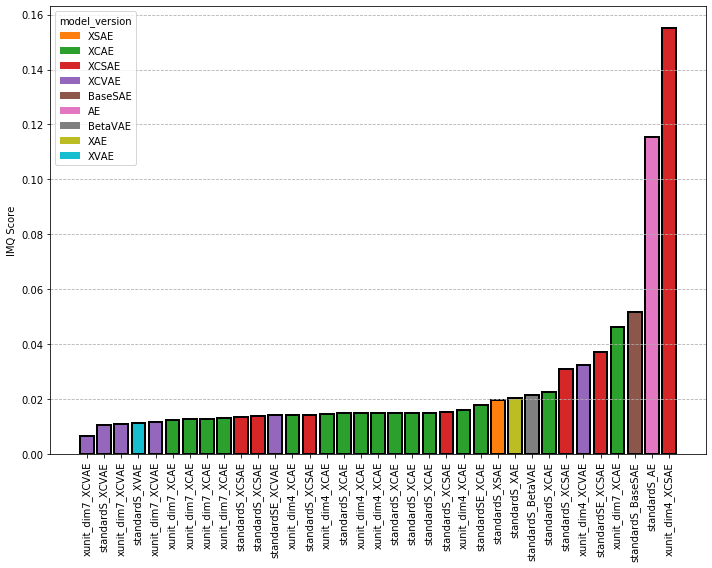

In [60]:
fig = plot_metrics(full_df2, metric_name="IMQ", key="model_version",
                   values=["standardS","standardSE"]+[f"xunit_dim{i}" for i in [4,7]], 
                   group_key="model_name", key_name_in=True, title_in=False, figsize=(10,8))
#fig = plot_metrics(full_df, metric_name="FID", key="dataset",value="3DS", group_key="model_version",figsize=(6,6))

In [ ]:
fig = plot_metrics(full_df, metric_name="IRS", key="dataset",value="MNIST", group_key="model_version",figsize=(8,8))
fig = plot_metrics(full_df, metric_name="IRS", key="dataset",value="3DS", group_key="model_name",figsize=(6,6))

In [ ]:
#TODO: adjust plotting for visual datasets

In [11]:
full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4'])]

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,INV,EQV,SCN,FID_trv,inference,INV_w,EQV_w,inferenceX,sparsity,model_family
14,SAE,standardS,MNIST,11.0,0.002397,0.051606,-37.119141,0.248815,NaN,0.674850,...,0.672559,NaN,5.017962,NaN,1.0000,0.676788,NaN,NaN,NaN,SAE
15,VAE,standardS,MNIST,11.0,0.001683,0.021405,-35.843693,0.146933,NaN,0.581233,...,0.804501,NaN,2.299924,NaN,0.7734,0.709551,NaN,NaN,NaN,VAE
16,AE,standardS,MNIST,11.0,0.004981,0.115413,-66.567383,0.448714,NaN,0.728408,...,0.828893,NaN,4.018983,NaN,0.9921,0.830705,NaN,NaN,NaN,AE
21,XVAE,standardS,MNIST,11.0,0.001587,0.011306,-43.764526,0.156623,NaN,0.598862,...,0.840001,0.991257,3.292447,82.933933,0.8358,0.682406,0.985526,0.8134,NaN,VAE
23,XCAE,standardS,MNIST,11.0,0.001860,0.022484,-42.722870,0.208227,NaN,0.635522,...,0.880916,0.978832,5.641273,79.229177,0.9686,0.883969,0.979923,0.9750,NaN,AE
24,XCSAE,standardS,MNIST,11.0,0.002234,0.031179,-38.540421,0.216116,NaN,0.639433,...,0.738277,0.941617,5.513371,79.618860,0.9766,0.796955,0.944498,0.9666,NaN,SAE
25,XAE,standardS,MNIST,11.0,0.002038,0.020385,-33.257256,0.170206,NaN,0.697051,...,0.716242,0.949304,5.378277,78.792896,0.9688,0.739611,0.951088,0.9687,NaN,AE
26,XSAE,standardS,MNIST,11.0,0.002308,0.034846,-34.935459,0.205883,NaN,0.660350,...,0.729228,0.933393,5.337350,80.216930,0.9766,0.770027,0.941841,0.9786,NaN,SAE
28,XCVAE,standardS,MNIST,11.0,0.001528,0.010458,-50.404320,0.210037,NaN,0.506021,...,0.766186,0.962740,2.364816,82.289695,0.8359,0.653691,0.950733,0.8318,NaN,VAE
36,XCAE,standardS,MNIST,37.0,0.002044,0.017828,-37.047951,0.172622,NaN,0.604936,...,0.835025,0.973715,5.632848,81.174608,0.9376,0.841968,0.975136,0.9454,0.208333,AE


In [332]:


sns.set_context("poster", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})   
sns.set_theme(style="whitegrid")

In [33]:
full_df2.loc[full_df2['dataset']=='celeba']

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,SCN,FID_trv,inference,INV_w,EQV_w,inferenceX,sparsity,SCN_w,model_family,model_type
173,AE,v32_big,celeba,11.0,0.002373,0.000124,-28.327208,0.013833,0.203130,0.571097,...,0.974172,93.384689,NaN,0.179351,NaN,NaN,NaN,0.974171,AE,N
174,XCAE,v32_big,celeba,11.0,0.002407,0.000317,-34.893906,0.017043,0.196120,0.569201,...,0.941401,101.361414,NaN,0.078484,0.986445,NaN,0.242188,0.941402,AE,XC
175,XCAE,v32_x4_big,celeba,11.0,0.002612,0.000396,-34.404881,0.017690,0.184720,0.593150,...,0.943511,90.629398,NaN,-0.118168,0.978018,NaN,0.242188,0.943511,AE,XC
176,XCAE,v32_bigE,celeba,11.0,0.002424,0.000472,-36.775711,0.018536,0.199731,0.575909,...,0.938961,109.335410,NaN,0.091317,0.986907,NaN,0.242188,0.938961,AE,XC
177,VAE,v32_big,celeba,11.0,0.001474,0.004888,-85.866859,0.020207,0.181756,0.524605,...,0.343154,107.505998,NaN,0.681030,NaN,NaN,NaN,0.343154,VAE,N
178,XVAE,v32_big,celeba,11.0,0.001655,0.003900,-54.507042,0.009488,0.176161,0.509505,...,0.300828,105.090041,NaN,0.562249,0.997483,NaN,0.242188,0.300828,VAE,X
179,XVAE,v32_x4_big,celeba,11.0,0.001525,0.004499,-54.954552,0.010312,0.178624,0.545815,...,0.283789,104.325458,NaN,0.452264,0.994268,NaN,0.242188,0.283789,VAE,X
180,XCVAE,v32_big,celeba,11.0,0.001472,0.002903,-52.544098,0.011378,0.155652,0.575977,...,0.267317,109.962289,NaN,0.600818,0.996325,NaN,0.242188,0.267317,VAE,XC
181,XAE,v32_big,celeba,11.0,0.002367,0.000822,-45.630249,0.022212,0.203760,0.585781,...,0.930373,99.462214,0.781105,0.313720,0.986266,0.778238,0.242188,0.930373,AE,X
182,XCVAE,v32_x4_big,celeba,11.0,0.001934,0.005021,-53.338669,0.010359,0.182559,0.567620,...,0.269157,107.108383,NaN,0.477120,0.990510,NaN,0.242188,0.269157,VAE,XC


[Text(0, 0.5, ''), Text(0.5, 0, '')]

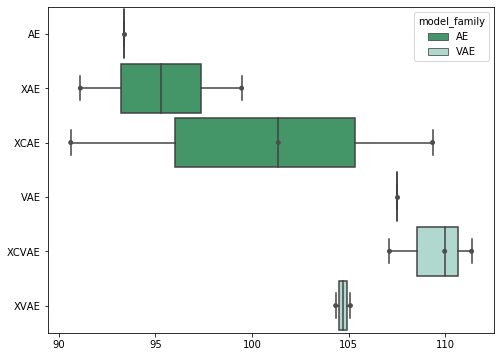

In [39]:
fig = plt.figure(figsize=(8,6))
#df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','xunit_dim7', 'standardSE', 'standard', 'standardE'])]
df = full_df2.loc[(full_df2['dataset']=='celeba')]
df = df.sort_values(by=["model_family","model_name"])
#df = df.drop(df.loc[df['EQV'].isna()].index)
#sns.boxplot(x='INV',y="model_name", palette="Blues",data=df, width=2.0, hue="model_family").set(xlabel=None)
palette="BuGn_r"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.boxplot(x='FID_trv',y="model_name", data=df,  
            palette=palette, hue="model_family", 
            dodge=False, width=.9).set(xlabel=None, ylabel=None)
sns.swarmplot(x='FID_trv',y="model_name", data=df, color=".3").set(xlabel=None, ylabel=None)

In [172]:
fig = plt.figure(figsize=(8,6))
df = full_df2.loc[full_df2['dataset']=='MNIST']
df = df.drop(df.loc[df['model_name']=="AVAE"].index)
df = df.sort_values(by=["model_family","model_name"])

<Figure size 576x432 with 0 Axes>

In [173]:
df1 = df[['model_type','model_family','model_name','model_version','FID_rec']].assign(FID=1)
df2 = df[['model_type','model_family','model_name','model_version','FID_gen']].assign(FID=2)
df3 = df[['model_type','model_family','model_name','model_version','FID_trv']].assign(FID=3)
cdf = pd.concat([df1, df2, df3])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['model_type',"model_family","model_name","FID"], value_vars=["FID_rec","FID_gen","FID_trv"])      # MELT

c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


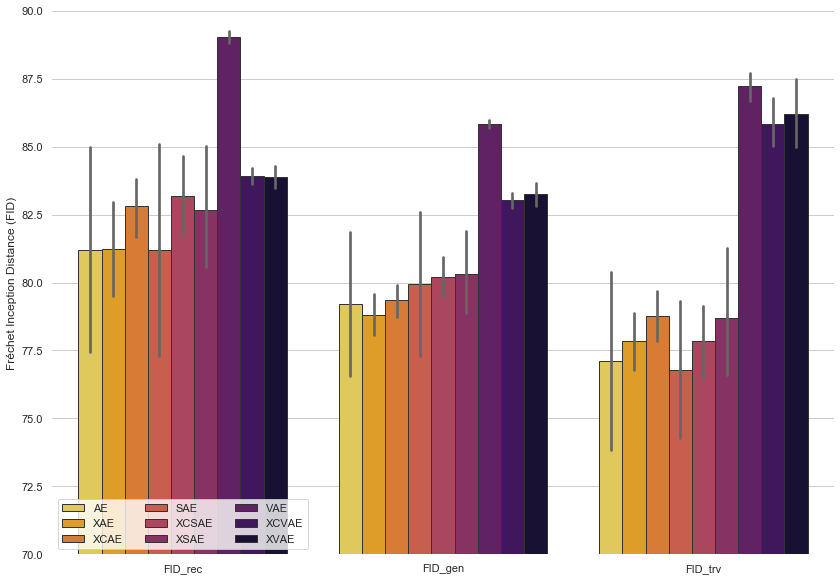

In [323]:
fig, ax = plt.subplots(figsize=(14,10))
palette="inferno_r"#sns.cubehelix_palette(8, start=.5, rot=-.75)
df = full_df2.sort_values(by=["model_family","model_name"])
ax = sns.barplot(x='variable',y="value", data=mdf,  
            palette=palette, hue="model_name", #hue_order=["AE","SAE","VAE"],
            ax=ax,  orient="v",errcolor=".4", edgecolor=".2")
ax.legend(ncol=3, loc="lower left", frameon=True)
ax.set(ylim=(70,90), ylabel="Fréchet Inception Distance (FID)",
       xlabel="")
sns.despine(left=True, bottom=True)

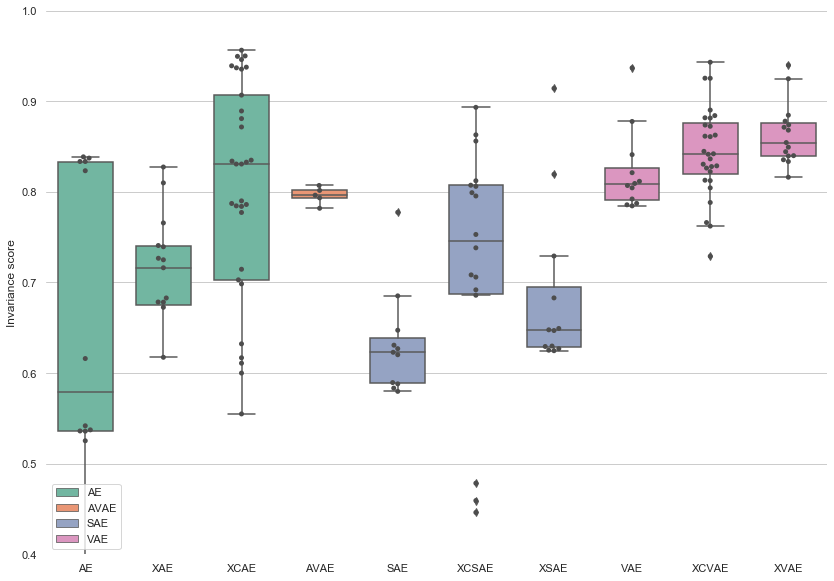

In [335]:
fig, ax = plt.subplots(figsize=(14,10))
#df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E',
#                                                  'xunit_dim7', 'standardSE', 'standard', 'standardE'])]
df = full_df2.sort_values(by=["model_family","model_name"])
df = df.drop(df.loc[df['INV'].isna()].index)
#sns.boxplot(x='INV',y="model_name", palette="Blues",data=df, width=2.0, hue="model_family").set(xlabel=None)
palette="Set2"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.boxplot(x='model_name',y="INV", data=df,  
            palette=palette, hue="model_family", 
            dodge=False, width=.7).set(xlabel=None, ylabel=None, ylim=(0.4,1.0))
sns.swarmplot(x='model_name',y="INV", data=df, color=".3").set(xlabel=None, ylabel="Invariance score")
ax.legend(ncol=1, loc="lower left", frameon=True)
sns.despine(left=True, bottom=True)

In [336]:

fname = fig_path / ("INV_scores.png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")


Saving to figures\INV_scores.png


[Text(0, 0.5, ''), Text(0.5, 0, '')]

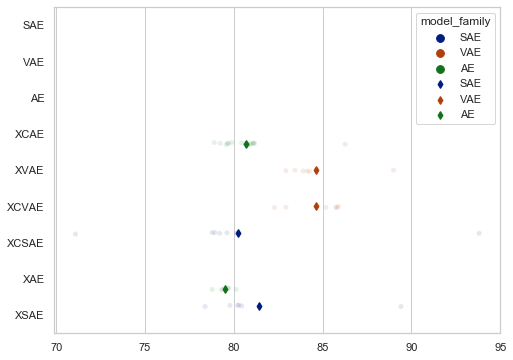

In [20]:
fig = plt.figure(figsize=(8,6))
df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','xunit_dim7', 'standardSE'])]
#sns.boxplot(x='INV',y="model_name", palette="Blues",data=df, width=2.0, hue="model_family").set(xlabel=None)
palette="dark"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.stripplot(x='FID_trv',y="model_name", data=df,  
            palette=palette, hue="model_family", dodge=True, alpha=.1, zorder=2).set(xlabel=None, ylabel=None, xlim=None)
sns.pointplot(x='FID_trv',y="model_name", data=df, palette=palette, hue="model_family",
              markers="d", scale=.75, ci=None, dodge=.8 - .8 / 3,
              join=False).set(xlabel=None, ylabel=None)

In [52]:
def is_Xnet(name):
    return 'X' in name
def is_XCnet(name):
    return 'XC' in name
    

c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWit

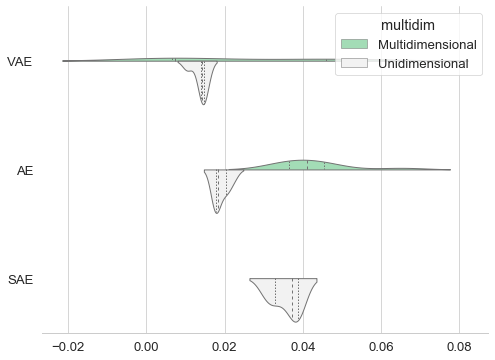

In [558]:
fig = plt.figure(figsize=(8,6))
df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','xunit_dim7', 'standardSE'])]
df['Xnet'] = df['model_name'].apply(is_Xnet)
df['multidim'] = df['model_version'].apply(multidim)
df['XCnet'] = df['model_name'].apply(is_XCnet)
df = df.drop(df.loc[df['XCnet']==False].index)
df = df.drop(df.loc[df['IMQ'].isna()].index)
#df = df.drop(df.loc[df['model_name']=="AVAE"].index)
#sns.boxplot(x='INV',y="model_name", palette="Blues",data=df, width=2.0, hue="model_family").set(xlabel=None)
palette="BuGn_r"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.violinplot(x='IMQ',y="model_family", data=df, hue="multidim", split=True, inner="quart", linewidth=1,
               palette={"Multidimensional": (0.6,0.9,0.7), "Unidimensional": ".95"}).set(xlabel=None, ylabel=None)
sns.despine(left=True)

No handles with labels found to put in legend.


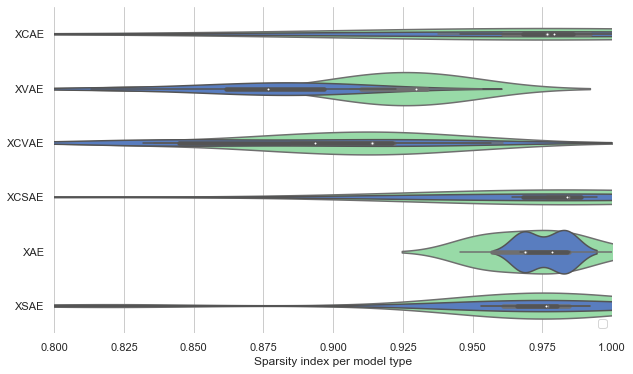

In [61]:

sns.set_context("poster", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})   
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(10, 6))

df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','xunit_dim7', 'standardSE', 'standard', 'standardE'])]
df = df.drop(df.loc[df['inferenceX'].isna()].index)
sns.set_color_codes("pastel")
sns.violinplot(x='inference',y="model_name", data=df, label="inference from N", dodge=False, 
            color="g").set(xlabel=None, ylabel=None, xlim=(0.8,1.0))
sns.set_color_codes("muted")
sns.violinplot(x='inferenceX',y="model_name", data=df, label="inference from Z", dodge=False, 
            color="b").set(xlabel=None, ylabel=None, xlim=(0.8,1.0))

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0.8,1.0), ylabel="",
       xlabel="Sparsity index per model type")
sns.despine(left=True, bottom=True)

[(0.7, 1.0), Text(0, 0.5, 'Average test accuracy'), Text(0.5, 0, '')]

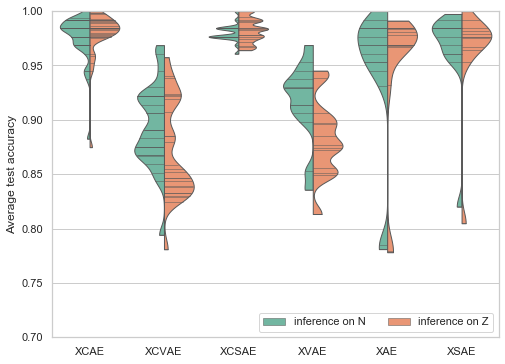

In [55]:

f, ax = plt.subplots(figsize=(8, 6))
df = full_df2#.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','xunit_dim7', 'standardSE', 'standard', 'standardE'])]
df = df.drop(df.loc[df['inferenceX'].isna()].index)
df_plot = df.melt(id_vars='model_name', value_vars=["inference", "inferenceX"])
def change_names(name):
    if name=="inference": return "inference on N"
    if name=="inferenceX": return "inference on Z"
df_plot['variable'] = df_plot['variable'].apply(change_names)
palette="Set2"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.violinplot(x='model_name',y="value", hue='variable', data=df_plot, split=True, 
               cut=0.0, scale="width", inner="stick", linewidth=1,
               palette=palette, bw=.2).set(xlabel=None, ylabel=None, ylim=(0.7,1.0))
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0.7,1.0), xlabel="",
       ylabel="Average test accuracy")
#sns.swarmplot(x='value',y="model_name", hue='variable', dodge=True, data=df_plot, color=".3").set(xlabel=None, ylabel=None)

In [510]:

def XC_type(version_name):
    if 'E' in version_name: 
        return "equivariance"
    return "invariance"
def XCnet(name):
    if 'XC' in name:
        return "Consistency training"
    return "Standard training"

def multidim(name):
    if 'xunit_dim' in name:
        return "Multidimensional"
    return "Unidimensional"

In [527]:
df.head()

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,FID_trv,inference,INV_w,EQV_w,inferenceX,sparsity,SCN_w,model_family,model_type,multidim
165,AE,standardS,MNIST,37.0,0.003975,0.089624,-63.172874,0.398186,NaN,0.706446,...,NaN,0.9922,0.833619,NaN,NaN,NaN,0.687115,AE,N,Unidimensional
166,AE,standardS,MNIST,17.0,0.003872,0.086816,-63.259392,0.393872,NaN,0.704463,...,NaN,0.9844,0.838509,NaN,NaN,NaN,0.704808,AE,N,Unidimensional
167,AE,standardS,MNIST,13.0,0.003912,0.087656,-63.358753,0.396296,NaN,0.703941,...,NaN,0.9844,0.836908,NaN,NaN,NaN,0.691824,AE,N,Unidimensional
168,AE,standardS,MNIST,121.0,0.003916,0.087945,-63.425961,0.393901,NaN,0.707785,...,NaN,0.9766,0.833336,NaN,NaN,NaN,0.688201,AE,N,Unidimensional
171,AE,standardS,MNIST,11.0,0.004981,0.115413,-66.567390,0.448716,NaN,0.728408,...,80.401451,0.9921,0.824769,NaN,NaN,NaN,0.624428,AE,N,Unidimensional


[(0.8652331233024597, 1.0043858885765078),
 Text(0, 0.5, 'Equivariance score (XC)'),
 Text(0.5, 0, '')]

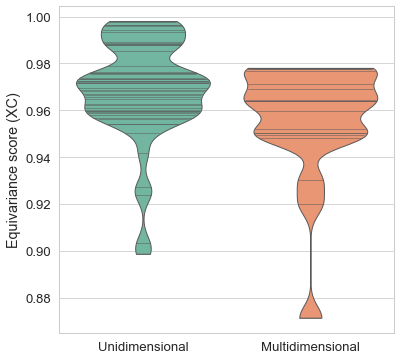

In [575]:


f, ax = plt.subplots(figsize=(6, 6))
df = full_df2.copy()#.loc[full_df2['model_version'].isin(['xunit_dim4E','standardSE'])]
df = df.sort_values(by=["model_family","model_name"])
df['multidim'] = df['model_version'].apply(multidim)
df['XCnet'] = df['model_name'].apply(is_XCnet)
df = df.drop(df.loc[df['XCnet']==False].index)
#df['XCtype'] = df['model_version'].apply(XC_type)
df = df.sort_values(by=["multidim"], ascending=False)

df = df.drop(df.loc[df['model_name']=="AVAE"].index)
df = df.drop(df.loc[df['dataset'].isin(["celeba"])].index)

palette="Set2"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.violinplot(x='multidim',y="EQV", data=df, split=True, 
               cut=0.0, scale="width", inner="stick", linewidth=1,
               palette=palette, bw=.2)
#ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylim=None, xlabel="", ylabel="Equivariance score (XC)")
#sns.swarmplot(x='value',y="model_name", hue='variable', dodge=True, data=df_plot, color=".3").set(xlabel=None, ylabel=None)

[(0.23683336973190308, 0.9906766057014464),
 Text(0, 0.5, 'Invariance score'),
 Text(0.5, 0, '')]

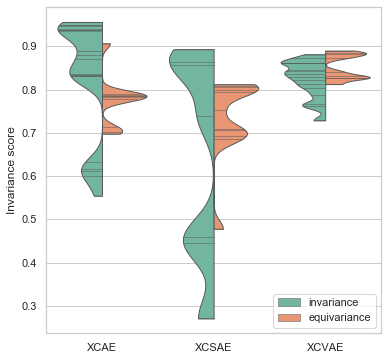

In [298]:

f, ax = plt.subplots(figsize=(6, 6))
df = full_df2.sort_values(by=["model_family","model_name"])

df = df#.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','standard','standardSE', 'standardE'])]
df['XCnet'] = df['model_name'].apply(is_XCnet)
df = df.drop(df.loc[df['XCnet']==False].index)
df = df.drop(df.loc[df['model_name']=="AVAE"].index)
df = df.drop(df.loc[df['dataset'].isin(["celeba"])].index)
df['XCtype'] = df['model_version'].apply(XC_type)
#df['XCnet'] = df['model_name'].apply(XCnet)

palette="Set2"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.violinplot(x='model_name',y="INV", hue='XCtype', data=df, split=True, 
               cut=0.0, scale="width", inner="stick", linewidth=1,
               palette=palette, bw=.2)
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylim=None, xlabel="", ylabel="Invariance score")
#sns.swarmplot(x='value',y="model_name", hue='variable', dodge=True, data=df_plot, color=".3").set(xlabel=None, ylabel=None)

In [576]:

fname = fig_path / ("EQV_multidim_XC.png")
f.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")


Saving to figures\EQV_multidim_XC.png


In [43]:
df.head()

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,EQV,SCN,FID_trv,inference,INV_w,EQV_w,inferenceX,sparsity,model_family,Xnet
3,XCSAE,standard,MNIST,11.0,0.001426,0.010699,-85.545578,0.133575,NaN,0.463532,...,137.217102,6.167468,NaN,NaN,NaN,NaN,NaN,NaN,SAE,True
19,XCAE,standardSE,MNIST,11.0,0.001849,0.018079,-35.558804,0.171073,NaN,0.677636,...,0.968723,5.571198,80.663075,0.9765,0.791295,0.969101,0.9843,NaN,AE,True
20,XVAE,standardS,MNIST,11.0,0.001587,0.011306,-43.764526,0.156623,NaN,0.598862,...,0.991257,3.292447,82.933933,0.8358,0.682406,0.985526,0.8134,NaN,VAE,True
21,XCVAE,standardSE,MNIST,11.0,0.001563,0.014160,-52.220730,0.219641,NaN,0.496950,...,0.989321,3.773677,82.936111,0.9218,0.737417,0.985190,0.9070,NaN,VAE,True
22,XCAE,standardS,MNIST,11.0,0.001860,0.022484,-42.722870,0.208227,NaN,0.635522,...,0.978832,5.641273,79.229177,0.9686,0.883969,0.979923,0.9750,NaN,AE,True


In [64]:
df.melt(id_vars='model_name', value_vars=["inference", "inferenceX"])

,model_name,variable,value
0,XCAE,inference,0.9765
1,XVAE,inference,0.8358
2,XCVAE,inference,0.9218
3,XCAE,inference,0.9686
4,XCSAE,inference,0.9766
...,...,...,...
147,XSAE,inferenceX,0.9818
148,XVAE,inferenceX,0.8507
149,XVAE,inferenceX,0.8744
150,XSAE,inferenceX,0.9843


In [227]:

fname = fig_path / ("FID_all2.png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")


Saving to figures\FID_all2.png


In [ ]:
for k in full_df.columns[1:8]: # disentanglement
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='model_name',y=k,data=full_df,
                palette="Blues")

In [ ]:
for k in scores_df.columns[3:]: # orthogonality
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='data_version',y=k,data=scores_df, palette="Greens")

In [ ]:
# finally visualising 
for k in scores_df.columns[3:]: # disentanglement
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='model_name',y=k,data=scores_df, palette="Blues")

In [ ]:
# finally visualising 
for k in scores_df.columns[3:-1]: # disentanglement
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='data_version',y=k,data=scores_df, palette="Greens")

# Invariance Scoring

In [501]:
model_names = ["AE","XAE","XCAE","BetaVAE","XVAE","XCVAE","BaseSAE","XSAE","XCSAE"]
model_names = ["XCAE"]
model_versions = ["StandardS","xunit_dim4"]
model_versions = ["xunit_dim4"]
i = 0
for model_name in model_names: 
    for v in model_versions: 
        if 'X' not in model_name and v in ["xunit_dim4","v32_x4_big"]: continue
        params = {"model_name":model_name,
                  "model_version":v,
                  "data" : "MNIST"}

        # load handler
        handler = ModelHandler.from_config(**params)
        handler.config["logging_params"]["save_dir"] = "./logs"
        handler.load_checkpoint('final')

configs/models/XCAE/xunit_dim4.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading selected checkpoint at logs\XCAE\xunit_dim4_MNIST\checkpoints/final.ckpt
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]

In [502]:
params= {
    'intervention_type':'noise',
    'num_interventions':100, 
    'num_samples':200,
    'store':True, 
    'load':True, # note: when load=True the std_devs and intv_mags are not returned
    'random_seed':23,
    'num_batches':10,
    'mode':'X',
    'normalise':False,
    'verbose':True}

#invariance_matrix, std_devs = handler.evaluate_invariance(**params)
invariance_matrix = handler.evaluate_invariance(**params)

Scoring model's response map invariance to noise interventions.
Loading invariances matrix


In [503]:
invariance_matrix, std_devs = invariance_matrix
invariance_matrix

ValueError: too many values to unpack (expected 2)

In [504]:
std_devs

tensor([[0.9792, 1.0111, 0.9999, 1.0396, 1.0110, 0.9739],
        [0.3695, 0.6029, 0.6034, 0.6118, 0.5990, 0.5683]], device='cuda:0')

In [505]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
figure_params = {"figsize":(8,8), "nrows":3, "N":100, "markersize":10, "font_scale":10, "cbar":False}

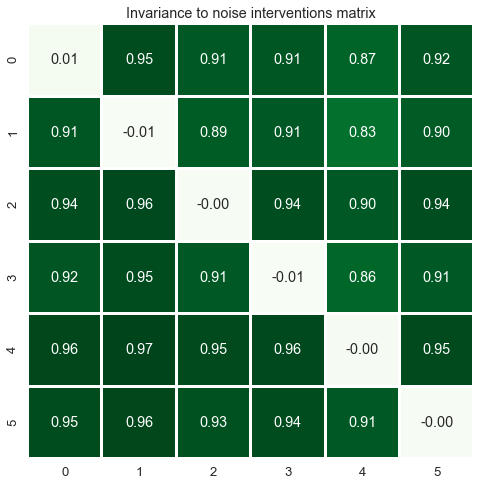

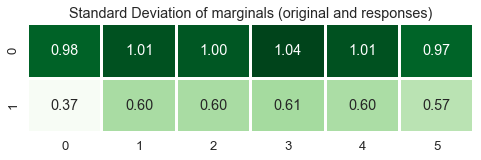

In [506]:
fig = handler.visualiser.plot_heatmap(invariance_matrix.cpu(), 
                                      title="Invariance to noise interventions matrix", 
                                      threshold=0., 
                                      **figure_params)
fig2 = handler.visualiser.plot_heatmap(std_devs.view(2,6).cpu(), 
                                      title="Standard Deviation of marginals (original and responses)", 
                                      threshold=0., figsize=(8,2))

In [46]:
print(torch.sum(invariance_matrix.cpu()*(1-torch.eye(6))))

tensor(25.1000)


In [ ]:
torch.sum((((1. - invariance_matrix.cpu())*torch.eye(6)) + invariance_matrix.cpu()*(1-torch.eye(6))))

In [507]:

fname = fig_path / ("inv_mat_"+model_name+"_"+v+".png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")


Saving to figures\inv_mat_XCAE_xunit_dim4.png


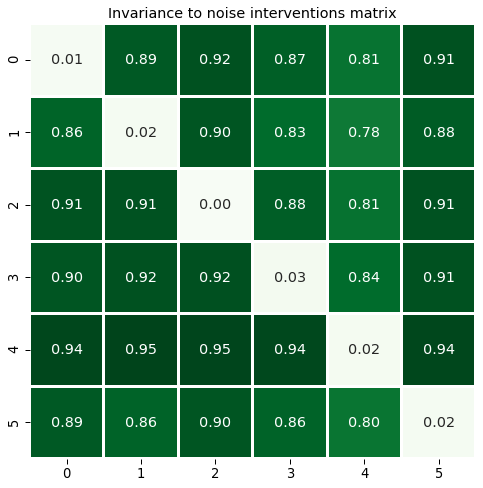

In [34]:

fname2 = fig_path / ("std_devs_"+model_name+"_E"+".png")
fig2.savefig(fname2, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname2}")

# Equivariance

In [479]:
model_name = "XCAE"
model_version = "standardSE"
params = {"model_name":model_name,
          "model_version":model_version,
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')

configs/models/XCAE/standardSE.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading selected checkpoint at logs\XCAE\standardSE_MNIST\checkpoints/final.ckpt
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]

In [480]:
params= {
    'intervention_type':'noise',
    'num_interventions':100, 
    'num_samples':100,
    'store':True, 
    'load':True, # note: when load=True the std_devs and intv_mags are not returned
    'random_seed':23,
    'num_batches':10,
    'mode':'X',
    'prior_mode':'posterior',
    'normalise':True,
    'verbose':True}

equivariance_matrix = handler.evaluate_equivariance(**params)

Scoring model's response map equivariance to noise interventions.
Loading equivariance matrix


In [481]:
sd_dev

NameError: name 'sd_dev' is not defined

In [ ]:
#equivariance_matrix, std_dev = equivariance_matrix
equivariance_matrix

In [482]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
figure_params = {"figsize":(8,8), "nrows":3, "N":100, "markersize":10, "font_scale":10, "vmin":0.0, "vmax":1.0}

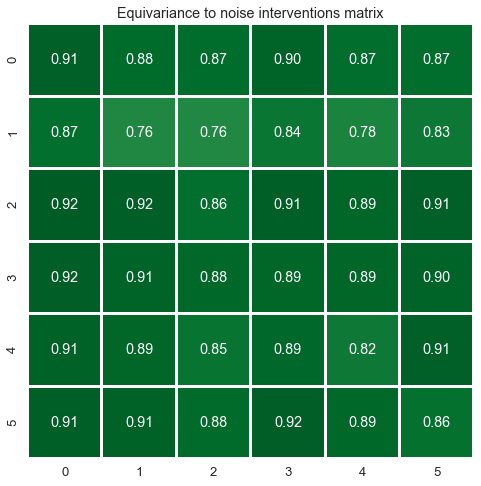

In [483]:
fig = handler.visualiser.plot_heatmap(equivariance_matrix.cpu(), 
                                      title="Equivariance to noise interventions matrix", 
                                      threshold=0., 
                                      **figure_params)

In [484]:
print(torch.sum(equivariance_matrix[:,:2])+torch.sum(equivariance_matrix[:,3:]))

tensor(26.4915, device='cuda:0')


In [485]:
fname = fig_path / ("eqv_mat_"+model_name+"_"+model_version+".png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")

Saving to figures\eqv_mat_XCAE_standardSE.png


# Self-consistency

configs/models/XCVAE/standardErandom_seed13.yaml
128
Initialising schedulers Manager...
Variational mode ON
Causal mode ON
Explicit mode ON
XCVAE model hanlder loaded.
Tau set to 1.0
Loading selected checkpoint at logs\XCVAE\standardErandom_seed13_MNIST\checkpoints/final.ckpt
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0



Saving to figures\SCNXCVAE_posterior.png


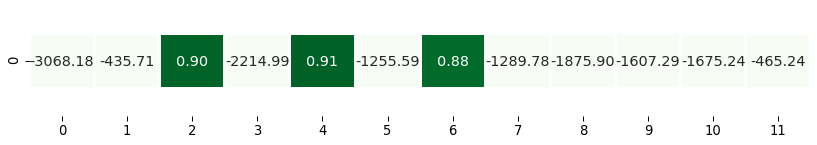

In [14]:
model_names=[#"AE","XAE","XCAE","BetaVAE","XVAE",
    "XCVAE"]#,"BaseSAE","XSAE","XCSAE"]
all_consistencies = []
figure_params = {"figsize":(14,2), "nrows":6, "N":100, "markersize":10, "font_scale":10, "vmin":0.0, "vmax":1.0}
for model_name in model_names:
    params = {"model_name":model_name,
              "model_version":"standardErandom_seed13",
              "data" : "MNIST"}

    # load handler
    handler = ModelHandler.from_config(**params)
    handler.config["logging_params"]["save_dir"] = "./logs"
    handler.load_checkpoint('final')
    handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
    handler.reset_tau(100000)
    consistencies = []
    prior_mode="posterior"
    #for prior_mode in ["posterior","hybrid","uniform"]:
    params= {'num_samples':1000,
            'random_seed':23,
            'num_batches':10,
            'prior_mode':prior_mode,
            'normalise': True,
            'verbose':True, 
            'level':1}
    with torch.no_grad():
        consistency, std_dev = handler.evaluate_self_consistency(**params)
        #consistencies.append(consistency)
    consistencies = consistency#torch.vstack(consistencies)
    fig = handler.visualiser.plot_heatmap(consistencies.view(1,-1).cpu(), 
                                  title="", 
                                  threshold=0., 
                                  **figure_params)
    del handler
    fname = fig_path / ("SCN"+model_name+"_"+prior_mode+".png")
    fig.savefig(fname, bbox_inches='tight', pad_inches=0)
    print(f"Saving to {fname}")


In [168]:
all_consistencies = torch.vstack(all_consistencies)

In [169]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])

In [170]:
figure_params = {"figsize":(8,2), "nrows":6, "N":100, "markersize":10, "font_scale":10, "vmin":0.0, "vmax":1.0}

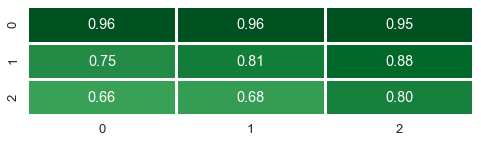

In [171]:
fig = handler.visualiser.plot_heatmap(all_consistencies.T.view(3,-1).cpu(), 
                                      title="", 
                                      threshold=0., 
                                      **figure_params)

In [ ]:
fig2 = handler.visualiser.plot_heatmap(std_dev.view(2,6).cpu(), 
                                      title="Standard Deviation of marginals (original and responses)", 
                                      threshold=0., figsize=(8,2))

In [172]:

fname = fig_path / ("all_SCN.png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")


Saving to figures\all_SCN.png


## Entropy of causal dimensions

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"multidim",
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint()
handler.reset_tau(100000)

In [ ]:
params= {'num_batches':10}

entropies = handler.score_causal_vars_entropy(**params)

In [ ]:
entropies

In [ ]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
figure_params = {"figsize":(handler.model.latent_size+2,2), "nrows":1, "N":100, "markersize":10, "font_scale":10, "vmin":0.0, "vmax":1.0}

In [ ]:
fig = handler.visualiser.plot_heatmap(entropies.view(1,-1).cpu(), 
                                      title="Entropies", 
                                      threshold=0., 
                                      **figure_params)

In [486]:
# collecting entropy for all the XCAE standardS model to compare 
all_entropies = []
model_versions = ["standardS","multidim"]+[f"xunit_dim{i}" for i in range(3,8)]
params = {"model_name":"XCAE", "model_version":"multidim", "data" : "MNIST"}
eparams= {'num_batches':10}
for v in model_versions: 
    # load model
    params["model_version"] = v
    handler = ModelHandler.from_config(**params)
    handler.config["logging_params"]["save_dir"] = "./logs"
    handler.load_checkpoint()
    handler.reset_tau(100000)
    # computing the entropies
    entropies = handler.score_causal_vars_entropy(**eparams)
    all_entropies.append(entropies)

configs/models/XCAE/standardS.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\standardS_MNIST\checkpoints\epoch=290-step=94911.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1

configs/models/XCAE/multidim.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\multidim_MNIST\checkpoints\epoch=181-step=59490.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 

configs/models/XCAE/xunit_dim3.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\xunit_dim3_MNIST\checkpoints\epoch=203-step=66863.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [

configs/models/XCAE/xunit_dim4.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\xunit_dim4_MNIST\checkpoints\epoch=276-step=90860.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [

configs/models/XCAE/xunit_dim5.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\xunit_dim5_MNIST\checkpoints\final.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]

configs/models/XCAE/xunit_dim6.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\xunit_dim6_MNIST\checkpoints\epoch=94-step=31125.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-

configs/models/XCAE/xunit_dim7.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\xunit_dim7_MNIST\checkpoints\epoch=196-step=64358.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [

In [487]:
_all_entropies = torch.vstack([all_entropies[0]]+all_entropies[2:]) # removing multidim
_all_entropies

tensor([[ 0.8884,  0.7885,  0.7482,  1.0801,  0.8263,  0.8981],
        [-0.0627,  0.6248, -0.7576,  0.5387,  0.4209,  1.6064],
        [ 0.6159,  0.1816,  1.1932,  1.3506,  2.0028,  2.9957],
        [ 0.5277,  0.0081,  0.1812, -0.3004, -1.0618,  1.3993],
        [ 1.3360,  0.9825,  0.5867,  3.4153,  3.0329,  4.2631],
        [ 2.5604,  2.0047,  2.7364,  2.8637,  2.3942,  4.4290]],
       device='cuda:0')

In [490]:
total = torch.sum(_all_entropies, dim=1)
total

tensor([ 5.2296,  2.3705,  8.3397,  0.7542, 13.6165, 16.9885], device='cuda:0')

In [493]:
x = [1] + list(range(3,8))
x

[1, 3, 4, 5, 6, 7]

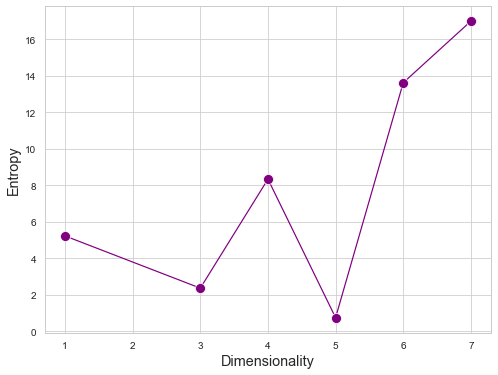

In [494]:
ylim = None; xlim=None; figsize=(8,6)
fig = plt.figure(figsize=figsize)
axi = sns.lineplot(x = x, y=total.cpu().numpy(), marker="o", markersize=10, color="purple")
axi.set(ylabel='Entropy', xlabel='Dimensionality')
axi.tick_params(axis="x", labelsize=10)
axi.tick_params(axis="y", labelsize=10)
if ylim is not None: axi.set(ylim=(0, ylim))
if xlim is not None: axi.set(xlim=(-xlim, xlim))

In [495]:
# looking at the other scores on the same models
_all_scores = []
scores = ["FID_rec","FID_gen","EQV","INV","SCN"]
model_versions = ["standardS_MNIST"]+[f"xunit_dim{i}_MNIST" for i in range(3,8)]
for s in scores: 
    s_scores = []
    for v in model_versions: 
        s_scores.append(full_df.loc[full_df["model_version"] == v].loc[full_df["model_name"] == "XCAE"][s].item())
    _all_scores.append(s_scores)

c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [496]:
all_scores = torch.vstack([total.cpu(),torch.Tensor(_all_scores)])

In [497]:
x = [1] + list(range(3,8))
x = x*len(all_scores)

In [498]:
hue = [i for i in ['entropy']+scores for _ in range(6)]
hue

['entropy',
 'entropy',
 'entropy',
 'entropy',
 'entropy',
 'entropy',
 'FID_rec',
 'FID_rec',
 'FID_rec',
 'FID_rec',
 'FID_rec',
 'FID_rec',
 'FID_gen',
 'FID_gen',
 'FID_gen',
 'FID_gen',
 'FID_gen',
 'FID_gen',
 'EQV',
 'EQV',
 'EQV',
 'EQV',
 'EQV',
 'EQV',
 'INV',
 'INV',
 'INV',
 'INV',
 'INV',
 'INV',
 'SCN',
 'SCN',
 'SCN',
 'SCN',
 'SCN',
 'SCN']

In [499]:

import matplotlib.ticker as ticker

<Figure size 432x288 with 0 Axes>

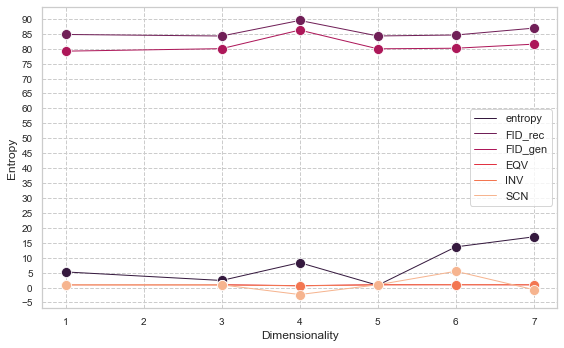

In [500]:
with sns.axes_style("whitegrid",  {'grid.linestyle': '--'}):
    sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})
    sns.despine(left=True)
    ylim = None; xlim=None; figsize=(8,5)
    fig = plt.figure(figsize=figsize)
    axi = sns.lineplot(x = x, y=all_scores.view(-1,).numpy(), marker="o", hue = hue, markersize=10, palette="rocket")
    axi.set(ylabel='Entropy', xlabel='Dimensionality')
    axi.tick_params(axis="x", labelsize=10)
    axi.tick_params(axis="y", labelsize=10)
    axi.yaxis.set_major_locator(ticker.MultipleLocator(5))
    if ylim is not None: axi.set(ylim=(0, ylim))
    if xlim is not None: axi.set(xlim=(-xlim, xlim))
    fig.tight_layout()

## Inference score

In [33]:
params = {"model_name":"XCAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')
handler.reset_tau(100000)

configs/models/XCAE/standardS.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading selected checkpoint at logs\XCAE\standardS_MNIST\checkpoints/final.ckpt
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]  

In [37]:
params= {'causal':False,
         'num_train':20000,
         'num_test':1000}

importance_matrix, train_acc, test_acc = handler.evaluate_inference(**params)

Starting training inference model...
Training complete in 0m 19s
Average test Acc: 0.969000


In [35]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])

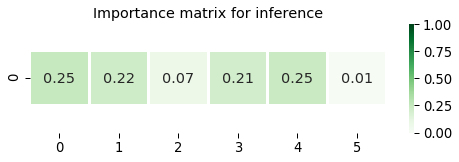

In [36]:
figure_params = {"figsize":(8,2), "nrows":6, "font_scale":10, "vmin":0.0, "vmax":1.0}
_ = handler.visualiser.plot_heatmap(torch.Tensor(importance_matrix).view(1,6), 
                        title="Importance matrix for inference", threshold=0., **figure_params)